## Purpose 

In this notebook we will explore several datasets in an attempt at providing answers to long debated sprinting questions. The 2 main datasets in use will be the Mens 100m performance by athlete (from [AthleteFirst](https://www.athletefirst.org/wp-content/uploads/2025/06/Mens-100m-by-athlete-20250520.pdf)) and Mens 200m Performances sourced from various Diamond League performances ([such as this](https://www.omegatiming.com/File/000203040102010101FFFFFFFFFFFF49.pdf)) as well as Mens 200m Performances sourced from AthletesFirst (please see the References section in the README for a full list of all resources used)

## Questions/Motivation:
The hope here is twofold: One, to use some data to provide more empirical answers to questions that are often decided by tradition / dogma and Two, selfishly for my own gain a I am a sprinter myself the outcome of this research could provide me some helpful insight into training methods
1. Is there a big difference between 100m and 200m race model? ie curve running notwithstanding, is it beneficial to instruct athletes to run the 200 differently than the 100m?
2. Is there a big difference between what factors affect a good race 100 vs 200 or, are there any measureable factors (reaction time, time to 30m etc) that are more statistically significant in one race over the other?
3. Is speed to a certain meter mark an indicator of success?
4. How does stride length (# of strides) break down for the 100 (avg, distribution etc) and the 200, how do those compare at the 100m mark?
    * Note we will need to use the 100 and 200m combined by athlete data for this
5. How significant is Reaction Time in the 100 (correlated/stat signifigance) and 200? How does it differ between the 2?
    * Note we will need to use the Diamond League data for anything regarding 200m splits at the 10m level of granularity, and the 200m_combined_by_athlete.csv for questions regarding reaction time
6. Is deceleration of a certain % at a certain mark associated with a specific time? 
7. What is more significant in the 200, speed out the blocks or holding off deceleration (speed endurance)? 
8. What is more significant in the 100, speed out of the blocks or holding off deceleration (speed endurance)?


In [72]:
%pip install seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [82]:
import pandas as pd
import seaborn as sns
mens_100 = pd.read_csv('Mens_100m_formatted.csv')
mens_100.drop(['Unnamed: 21','Unnamed: 22','Unnamed: 0'],axis=1,inplace=True)
mens_100 = mens_100.rename(columns={'100 m ':'100 m'})

# first and foremost, drop any times that are recorded as 'faster' than the current men's world record
mens_100 = mens_100[mens_100['100 m'] >= 9.58]
# next, lets make sure we have complete records (times from 10m-100m)
mens_100.dropna(subset=['10 m','20 m','30 m','40 m','50 m','60 m','70 m','80 m','90 m','100 m'],inplace=True)

mens_100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1461 entries, 0 to 1733
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Athlete      1461 non-null   object 
 1   Meet Info    1461 non-null   object 
 2   Lane_Place   1461 non-null   object 
 3   Wind         1461 non-null   object 
 4   Date         1461 non-null   object 
 5   RT           851 non-null    float64
 6   10 m         1461 non-null   float64
 7   20 m         1461 non-null   float64
 8   30 m         1461 non-null   float64
 9   40 m         1461 non-null   float64
 10  50 m         1461 non-null   float64
 11  60 m         1461 non-null   float64
 12  70 m         1461 non-null   float64
 13  80 m         1461 non-null   float64
 14  90 m         1461 non-null   float64
 15  100 m        1461 non-null   float64
 16  Time         1461 non-null   object 
 17  0-30 m       0 non-null      float64
 18  30-60 m      0 non-null      float64
 19  60-90 m    

In [83]:
mens_100.columns

Index(['Athlete', 'Meet Info', 'Lane_Place', 'Wind', 'Date', 'RT', '10 m',
       '20 m', '30 m', '40 m', '50 m', '60 m', '70 m', '80 m', '90 m', '100 m',
       'Time', '0-30 m', '30-60 m', '60-90 m', 'Stride Rate'],
      dtype='object')

### Times
The times look like a moderately normal distribution, with slight skew right, near bi modal distrbution


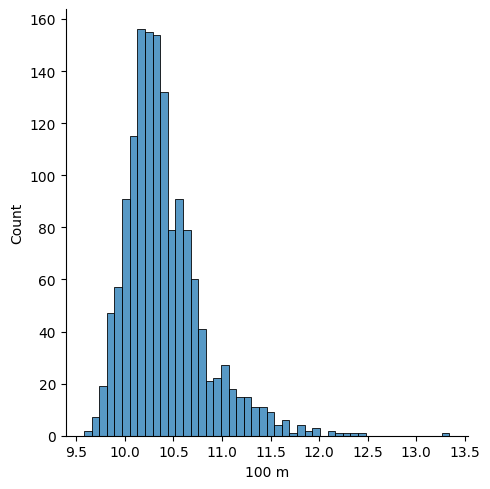

In [84]:
plot = sns.displot(mens_100,x="100 m")

In [85]:
mens_100['100 m'].describe()

count    1461.000000
mean       10.406256
std         0.409445
min         9.580000
25%        10.140000
50%        10.330000
75%        10.590000
max        13.340000
Name: 100 m, dtype: float64

## Cleaning some outliers
There are definitely some unrealistic times and splits here. Lets calculate 10m fly splits for all times, and drop any times that clock unlikely splits

In [86]:
import numpy as np
# gross way of doing it but programmaticaly creating these sucked
fly_frame = mens_100
fly_frame['fly_10']= fly_frame['10 m']
fly_frame['fly_20']= fly_frame['20 m'] - fly_frame['10 m']
fly_frame['fly_30']= fly_frame['30 m'] - fly_frame['20 m']
fly_frame['fly_40']= fly_frame['40 m'] - fly_frame['30 m']
fly_frame['fly_50']= fly_frame['50 m'] - fly_frame['40 m']
fly_frame['fly_60']= fly_frame['60 m'] - fly_frame['50 m']
fly_frame['fly_70']= fly_frame['70 m'] - fly_frame['60 m']
fly_frame['fly_80']= fly_frame['80 m'] - fly_frame['70 m']
fly_frame['fly_90']= fly_frame['90 m'] - fly_frame['80 m']
fly_frame['fly_100']= fly_frame['100 m'] - fly_frame['90 m']


fly_frame_corrs = fly_frame[['100 m','fly_10','fly_20','fly_30','fly_40','fly_50','fly_60','fly_70','fly_80','fly_90','fly_100']]
flys = ['fly_10','fly_20','fly_30','fly_40','fly_50',
        'fly_60','fly_70','fly_80','fly_90','fly_100']

# here we want to drop unrealistic performances, we want to select rows where either all their 10m splits are under 0.82s
# or the performance was faster than a 10.0. Its highly unlikely an athlete could go 0.82s in a 10m fly and still run under 10
# this shaves off about 20 performances that were likely very unrealisic 

mask = (fly_frame[flys] >= 0.82).all(axis=1) | (fly_frame['100 m'] < 10.0)
fly_frame = fly_frame[mask] 
fly_frame.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1446 entries, 0 to 1733
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Athlete      1446 non-null   object 
 1   Meet Info    1446 non-null   object 
 2   Lane_Place   1446 non-null   object 
 3   Wind         1446 non-null   object 
 4   Date         1446 non-null   object 
 5   RT           848 non-null    float64
 6   10 m         1446 non-null   float64
 7   20 m         1446 non-null   float64
 8   30 m         1446 non-null   float64
 9   40 m         1446 non-null   float64
 10  50 m         1446 non-null   float64
 11  60 m         1446 non-null   float64
 12  70 m         1446 non-null   float64
 13  80 m         1446 non-null   float64
 14  90 m         1446 non-null   float64
 15  100 m        1446 non-null   float64
 16  Time         1446 non-null   object 
 17  0-30 m       0 non-null      float64
 18  30-60 m      0 non-null      float64
 19  60-90 m    

### Stride Rate
Lets take a look at stride rate, as we can see, it looks like a normalish distribution, With a median of 47 strides. Fun fact: Usain bolt, an athlete with a famously long stride length still came in at 41 strides for his world record performance

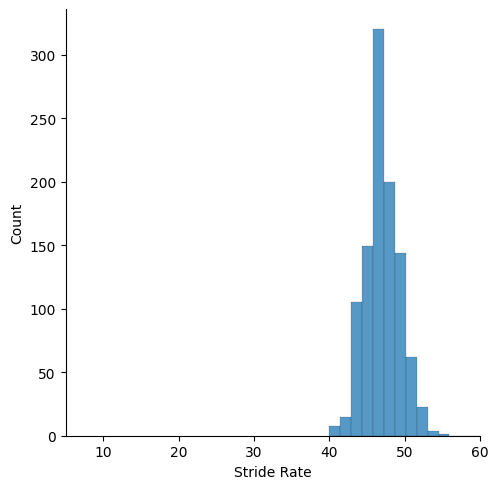

In [87]:
plot = sns.displot(fly_frame,x="Stride Rate",bins=300)
plot.set(xlim=(5, 60))

In [25]:
print(fly_frame['Stride Rate'].describe())


count    1033.000000
mean       47.499710
std        13.591288
min        40.000000
25%        45.700000
50%        47.000000
75%        48.500000
max       475.000000
Name: Stride Rate, dtype: float64


### Correlation and significance of stride rate and 100m time
* Is stride rate and 100m time correlated?
* If correlated, is stride rate statistically significant? 

In [27]:
# doesnt look great
stride_rate_100m_time = fly_frame[['Stride Rate','100 m']]
stride_rate_100m_time.corr()

,Stride Rate,100 m
Stride Rate,1.000000,0.091933
100 m,0.091933,1.000000


### Lets plot this to see on a scatter
As you can see, massive clustering bottom left

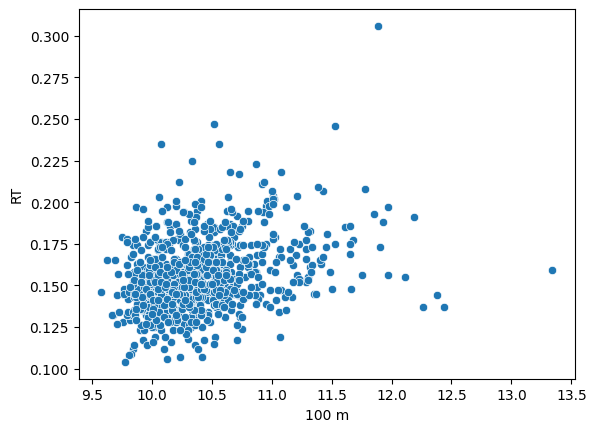

In [28]:
sns.scatterplot(x="100 m", y="RT", data=fly_frame);

### Stride Rate on World Class performances
Many consider a time of <= 10.00s to be "world class". Do we see any relationship between stride length there? Hmm, not so much


In [29]:
men_100m_worldclass = fly_frame[fly_frame['100 m'] <= 10.0]
stride_rate_100m_time = men_100m_worldclass[['Stride Rate','100 m']]
stride_rate_100m_time.corr()

,Stride Rate,100 m
Stride Rate,1.000000,0.208192
100 m,0.208192,1.000000


### Reaction Time
Now we can move on to reaction time, it looks somewhat normal, with a slight skew right, and the data seems to confirm that, with the mean being slightly larger than the median. Unfortunately, any hopes we might have had on identifying causal relationship seems a bit low here too, with moderate low correlation between Reaction Time and the entire samples overall 100m times, as well as a narrower subset of the sample focusing on athletes with a 100m time of <= 10.0s 

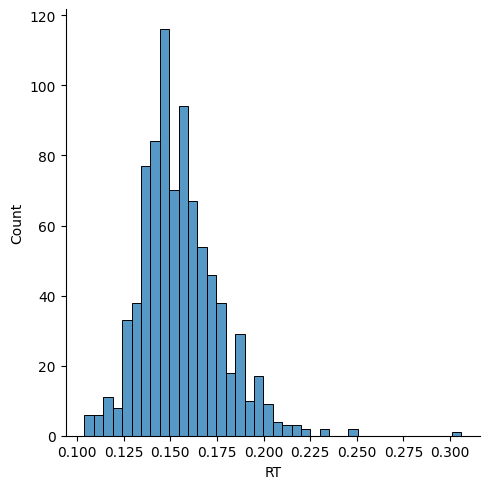

In [30]:
plot = sns.displot(fly_frame,x="RT")

In [31]:
print(fly_frame['RT'].describe())

count    848.000000
mean       0.155676
std        0.021322
min        0.104000
25%        0.142000
50%        0.153000
75%        0.166000
max        0.306000
Name: RT, dtype: float64


In [32]:
RT_100m_time = fly_frame[['RT','100 m']]
RT_100m_time.corr()

,RT,100 m
RT,1.000000,0.323037
100 m,0.323037,1.000000


In [33]:
men_100m_worldclass = fly_frame[fly_frame['100 m'] <= 10.0]
RT_100m_time = men_100m_worldclass[['RT','100 m']]
RT_100m_time.corr()

,RT,100 m
RT,1.000000,0.063852
100 m,0.063852,1.000000


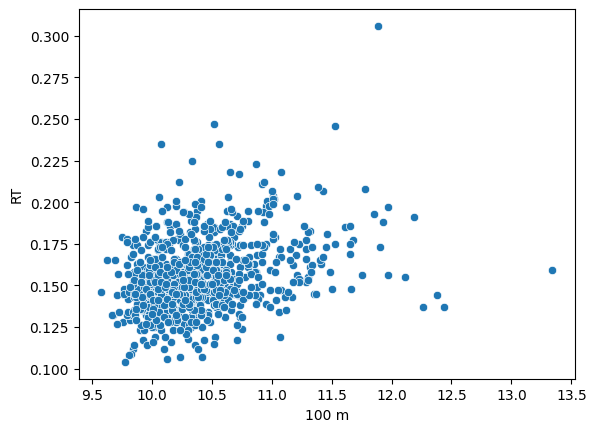

In [34]:
sns.scatterplot(x="100 m", y="RT", data=fly_frame);

### Time splits
Lets move on to identifying if there are any interesting correlaries between time segments. We have every 10m split, so I intend to use them. Lets first plot the distribution of these splits.

Right away we see something super interesting. The distribution density of 10m times are spread out, then approach a much more tight grouping (less variance) up to and including 40m, and then spread out again. This makes sense if you think about it, among athletes, the starts vary wildly, as do their ability to maintain their speed. We see this variance in the first and last splits respectively while nearly all athletes reach very close to a specific speed around 50m given enough time to do so. So now the question is, does it matter who gets there first? Or who can hold it longer? 

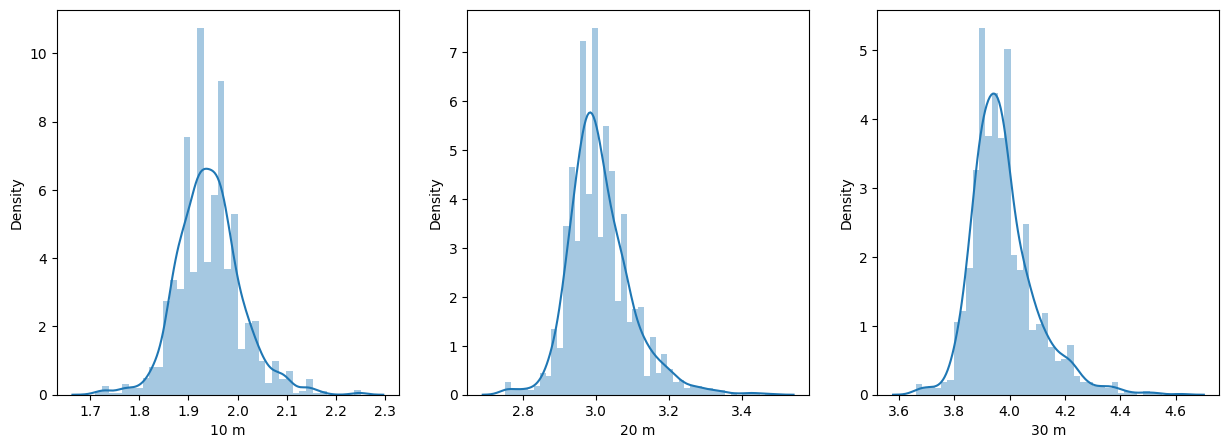

In [35]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

sns.distplot(fly_frame['10 m'], ax=ax1)
sns.distplot(fly_frame['20 m'], ax=ax2)
sns.distplot(fly_frame['30 m'], ax=ax3)

plt.show()



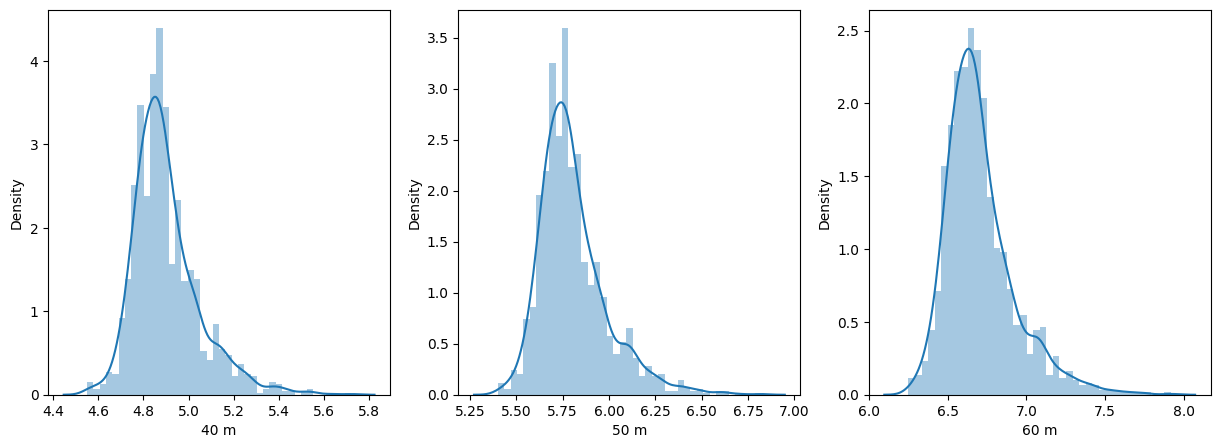

In [36]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

sns.distplot(fly_frame['40 m'], ax=ax1)
sns.distplot(fly_frame['50 m'], ax=ax2)
sns.distplot(fly_frame['60 m'], ax=ax3)

plt.show()

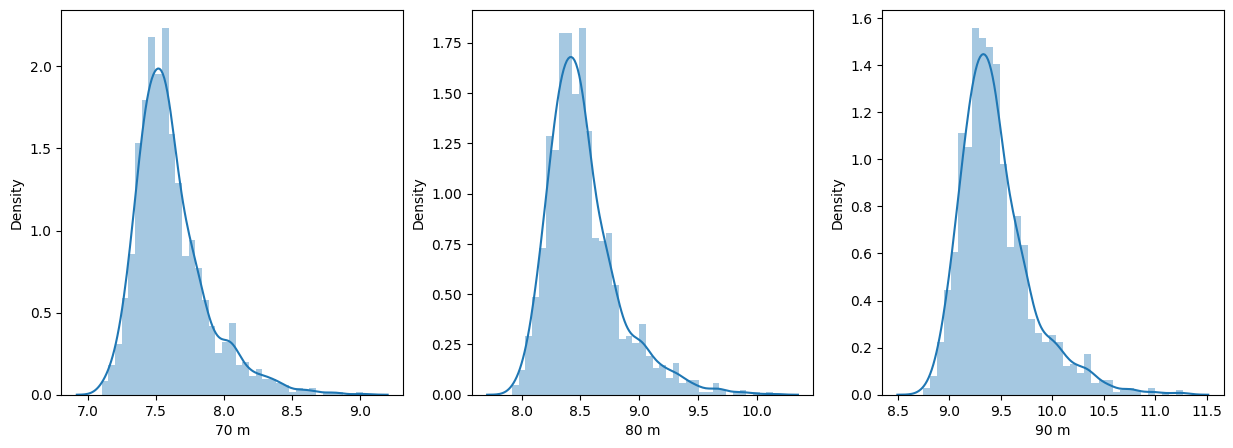

In [37]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

sns.distplot(fly_frame['70 m'], ax=ax1)
sns.distplot(fly_frame['80 m'], ax=ax2)
sns.distplot(fly_frame['90 m'], ax=ax3)

plt.show()

## 10m Flys
As we then look at 10m fly times, we see some interesting correlation coefficients for varying splits, increasing in correlation until 30-40 (fly_40) and 40-50 (fly_50) before jumping back up

In [88]:
fly_frame_corrs.corr()

,100 m,fly_10,fly_20,fly_30,fly_40,fly_50,fly_60,fly_70,fly_80,fly_90,fly_100
100 m,1.000000,0.677061,0.767652,0.876193,0.299995,0.316805,0.940774,0.932716,0.938786,0.908843,0.791977
fly_10,0.677061,1.000000,0.461637,0.601536,0.204594,0.192820,0.587072,0.556673,0.548145,0.501321,0.341452
fly_20,0.767652,0.461637,1.000000,0.706141,0.247687,0.258096,0.733096,0.717275,0.678017,0.608746,0.493264
fly_30,0.876193,0.601536,0.706141,1.000000,0.267234,0.308255,0.852734,0.830693,0.795327,0.711152,0.569983
fly_40,0.299995,0.204594,0.247687,0.267234,1.000000,-0.788895,0.293621,0.291019,0.278204,0.258148,0.197734
fly_50,0.316805,0.192820,0.258096,0.308255,-0.788895,1.000000,0.309250,0.308984,0.295267,0.271280,0.217343
fly_60,0.940774,0.587072,0.733096,0.852734,0.293621,0.309250,1.000000,0.910158,0.896156,0.835914,0.663878
fly_70,0.932716,0.556673,0.717275,0.830693,0.291019,0.308984,0.910158,1.000000,0.871957,0.847095,0.670591
fly_80,0.938786,0.548145,0.678017,0.795327,0.278204,0.295267,0.896156,0.871957,1.000000,0.866898,0.767842
fly_90,0.908843,0.501321,0.608746,0.711152,0.258148,0.271280,0.835914,0.847095,0.866898,1.000000,0.815535


### Velocity
Lets look at velocity distribution and correlation to confirm what we are seeing with times

In [101]:
# lets go ahead and make a velocity variable that can help us firm up our findings
velocitycors = []
for i in range(1,11):
    i=i*10
    vel_string = f"{i}m_velocity" # our velocity
    fly_string = f"fly_{i}" # our fly times
    
    fly_frame[vel_string] = 10 / fly_frame[fly_string]
    velocitycors.append(vel_string)
velocitycors.insert(0,'100 m')
fly_frame.dropna(subset=velocitycors,inplace=True)
fly_frame_vel_corrs = fly_frame[velocitycors]

fly_frame_vel_corrs.corr()
fly_frame

/var/folders/w_/x1l28kg103j3s4tk96h_n8840000gn/T/ipykernel_72392/1694650023.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fly_frame[vel_string] = 10 / fly_frame[fly_string]
/var/folders/w_/x1l28kg103j3s4tk96h_n8840000gn/T/ipykernel_72392/1694650023.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fly_frame.dropna(subset=velocitycors,inplace=True)


,Athlete,Meet Info,Lane_Place,Wind,Date,RT,10 m,20 m,30 m,40 m,...,10m_velocity,20m_velocity,30m_velocity,40m_velocity,50m_velocity,60m_velocity,70m_velocity,80m_velocity,90m_velocity,100m_velocity
0,"Abdel Wahed, Saif Raad (IRQ) (2002)",West Asian GP - 2025 Jetour Doha Meeting (Doha...,3 / 1,1.4 m/s,16-May-25,0.161,1.87,2.96,3.91,4.81,...,5.347594,9.174312,10.526316,11.111111,11.111111,11.363636,11.363636,11.111111,11.235955,10.416667
1,"Abeykoon, Yupun (SRI) (1994)","FINAL - 2024 Bauhaus Galan (Stockholm, SWE)",8 / 8,-1.0 m/s,02-Jun-24,NaN,1.95,3.02,3.98,4.90,...,5.128205,9.345794,10.416667,10.869565,11.111111,11.235955,11.235955,10.869565,10.000000,8.849558
2,"Abeykoon, Yupun (SRI) (1994)",National FINAL - 2024 Bauhaus Galan (Stockholm...,6 / 1,-1.6 m/s,02-Jun-24,0.157,1.94,2.98,3.95,4.86,...,5.154639,9.615385,10.309278,10.989011,11.363636,10.989011,10.989011,11.764706,11.111111,10.989011
3,"Achi-Yao, Harold (FRA) (1997)","Regional FINAL - 2025 Meeting de Paris (Paris,...",7 / 6,2.8 m/s,20-Jun-25,0.152,1.95,3.06,4.05,4.98,...,5.128205,9.009009,10.101010,10.752688,11.111111,11.111111,11.111111,11.111111,10.869565,9.900990
4,"Adam, Ibadulla (MDV) (2002)","Prelim 4 - 2024 Olympic Games (Paris, FRA)",5 / 5,0.2 m/s,03-Aug-24,0.161,1.92,3.01,3.98,4.92,...,5.208333,9.174312,10.309278,10.638298,11.111111,11.111111,10.752688,10.526316,10.309278,10.204082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729,"Zohri, Lalu Muhammad (INA) (2000)","Prelim 5 - 2024 Olympic Games (Paris, FRA)",2 / 2,-0.4 m/s,03-Aug-24,0.157,1.94,3.00,3.95,4.87,...,5.154639,9.433962,10.526316,10.869565,11.111111,11.235955,11.111111,10.869565,10.752688,10.638298
1730,"Zohri, Lalu Muhammad (INA) (2000)","FINAL - 2019 Seiko Golden Grand Prix (Osaka, JPN)",9 / 3,1.7 m/s,19-May-19,0.179,1.90,2.94,3.87,4.77,...,5.263158,9.615385,10.752688,11.111111,11.494253,11.627907,11.627907,11.363636,11.363636,10.989011
1731,"Zohri, Lalu Muhammad (INA) (2000)","FINAL - 2018 Asian Games (Jakarta, INA)",7 / 5,0.8 m/s,26-Aug-18,0.145,1.90,2.95,3.90,4.80,...,5.263158,9.523810,10.526316,11.111111,11.363636,11.494253,11.363636,11.111111,10.869565,10.526316
1732,"Zorzi, Axel (FRA) (1997) (T13)","Para FINAL - 2023 Prefontaine Classic (Eugene,...",3 / 4,0.0 m/s,17-Sep-23,0.166,2.06,3.19,4.20,5.19,...,4.854369,8.849558,9.900990,10.101010,10.204082,10.204082,10.101010,9.708738,9.708738,9.174312


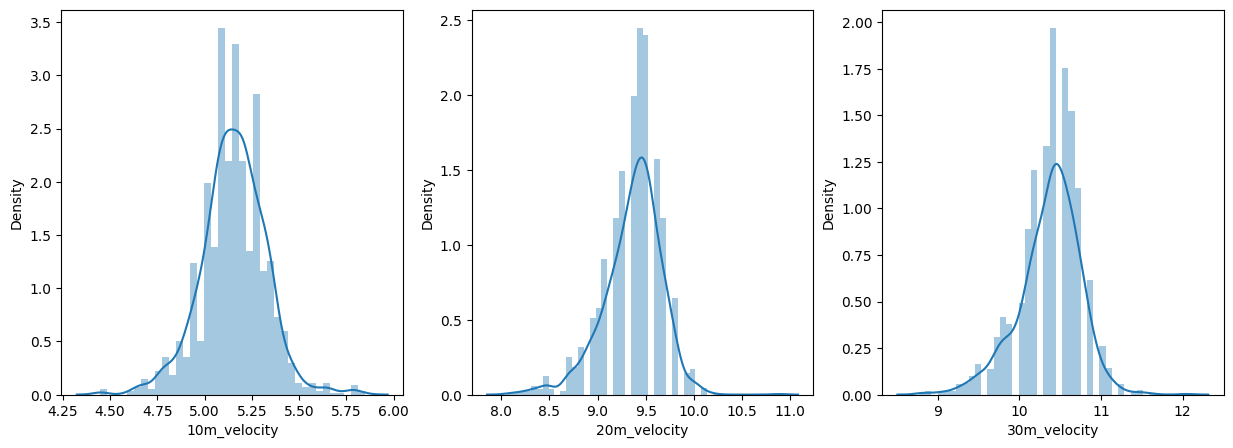

In [97]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

sns.distplot(fly_frame['10m_velocity'], ax=ax1)
sns.distplot(fly_frame['20m_velocity'], ax=ax2)
sns.distplot(fly_frame['30m_velocity'], ax=ax3)

plt.show()

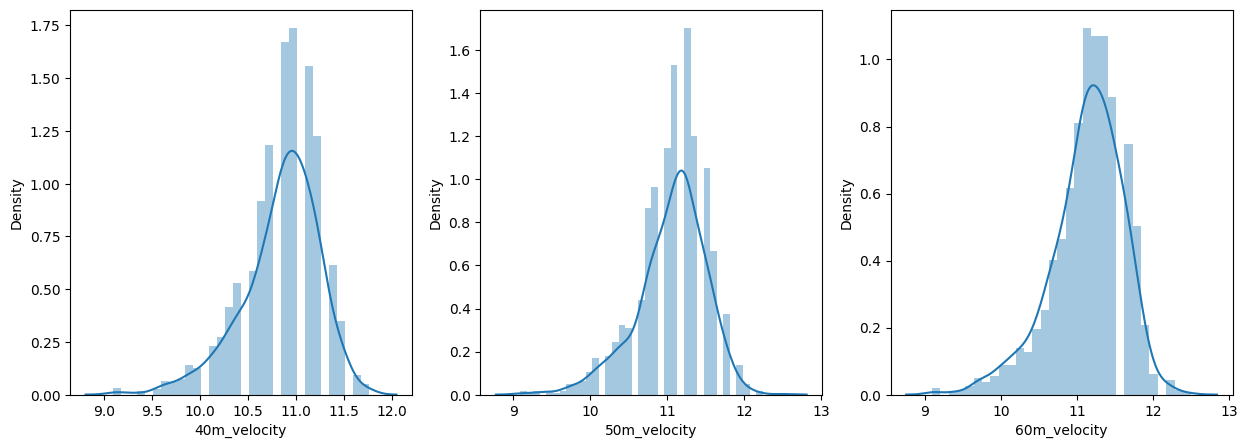

In [94]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

sns.distplot(fly_frame['40m_velocity'], ax=ax1)
sns.distplot(fly_frame['50m_velocity'], ax=ax2)
sns.distplot(fly_frame['60m_velocity'], ax=ax3)

plt.show()

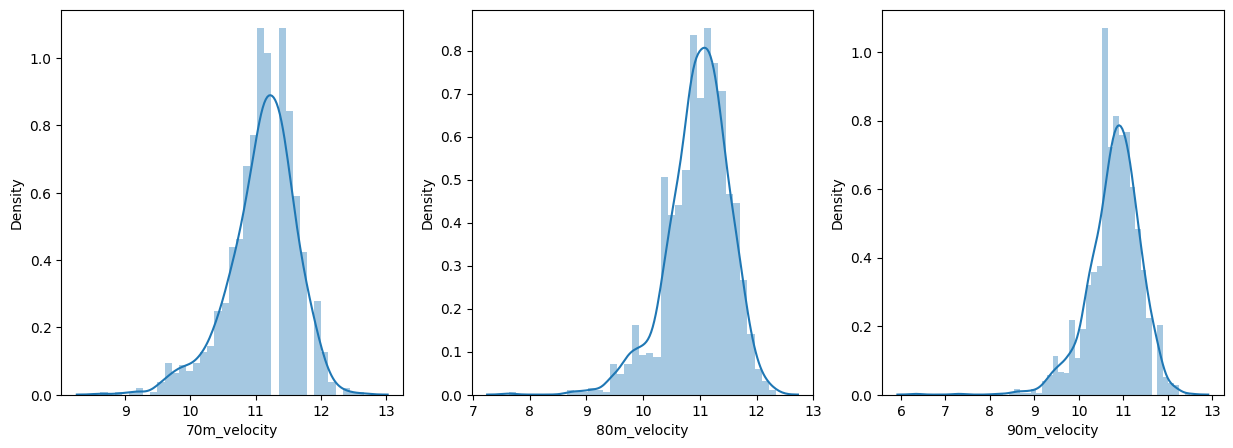

In [95]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

sns.distplot(fly_frame['70m_velocity'], ax=ax1)
sns.distplot(fly_frame['80m_velocity'], ax=ax2)
sns.distplot(fly_frame['90m_velocity'], ax=ax3)

plt.show()

### Interpretation of results
Interesting! We see increating correlation and then a massive drop off for the 30-40, and 40-50 stretch, but back to increasing correlation (and highly correlated) starting in the 50-60 split range and then dropping again at the end of the race as the athletes decelerate. Our visualizations offer some confirmation at first which again makes sense, the longer the fly split, the slower you are overall. 

But what is happening with fly_40 and fly_50 ? Well, in the statistical sense it does appear that there is low correlation, as in, the athletes fly times here have little effect on their 100m time. But lets think about whats happening here during the race, the athlete is likely at top speed, so there is no chance for them to get faster! What this data suggests is that how an athlete runs the start of the race and finishes the end of the race are more correlated to their overall times, than whatever top end speed they clock in the middle! And since most humans are not Usain Bolt, it makes sense that most high-level athletes have relatively similar top end speeds, thus explaning the near vertical line indicating most athletes were running the same speed during these splits, even if their finishing times were different!

So we can say based on the data that our Pearson Correlation, <i>r</i> increases on each 10m interval before dropping sharply between 30m to 50m before then jumping back up to a very strong positive correlation that only decreases mildly as you approach the end of the race. If we choose an alpha of 0.05, then we can test our p values to see that those 10m fly intervals are both correlated, and statisitically significant, as p < alpha in all the fly segments 

Fly_60 (an athletes split between 50m and 60m) has the highest correlation coefficient (0.936 rounded to 3 dec points) to 100m time, meanining as there is a near linear relationship. In simple terms, this split more than any other split affects the outcome of your race. A slower time clocked at this split of the race is highly correlated with a slower time overall. 

### Conclusions
Lets consider the following: the data suggest that from 30-40m, and 40-50m (thats fly_40 and fly_50) most athletes are running about the same split. Theres much, much less variance here. We also can see that at 50m, athletes times and velocities begin to spread out again. Whats happening here is that athletes are accelerating up until about 30m where they achieve their top speed somewhere between 30 and 40m and begin decelerating some time after 40m (as the velocities and splits clocked at 50 begin to spread again). During the time they are at top speed, most athletes are running at about the same speed, which explains why this segment of the race is not as correlated as the others; the athletes are all running nearly similar times here, but then go on to finish the race with wildly different times. At this point in the race you would likely observe all the athletes tied in the middle of the track, but as the race progresses even 10m meters, some would pull away while others lag behind.

<b>If we take it to be true that deceleration is occurring at some rate for athletes during the 40m-50m split, and we also remember that the segments of the race with the highest correlation to performance is between 50m to 60m ie  <i>the split of the race that comes right after deceleration begins </i> the data seem to suggest that <i>delaying deceleration</i> after top speed has been reached is the most significant on an athlete's overall performance in the 100m sprint</b>



## 100m times as a function of 10m splits

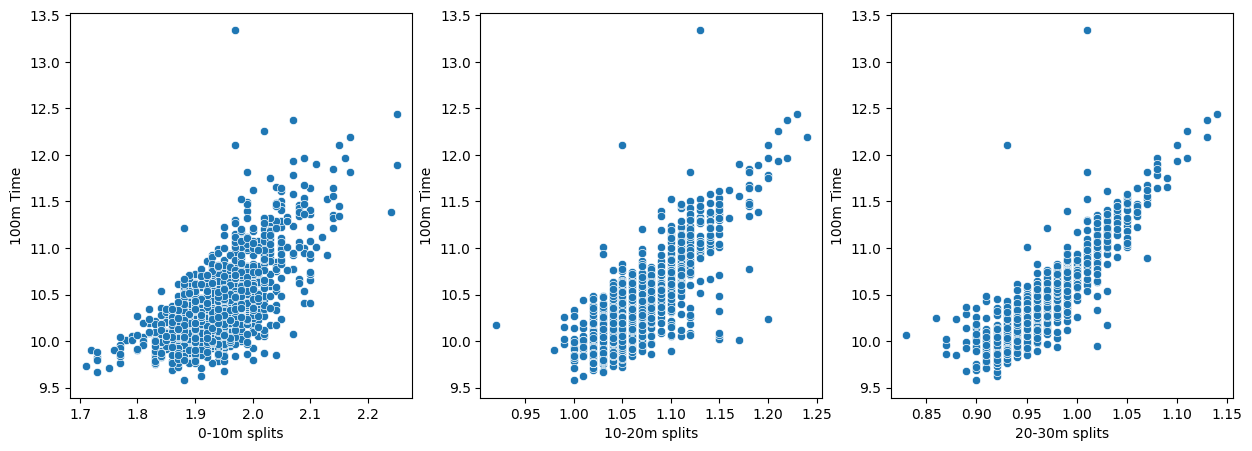

In [102]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

sns.scatterplot(x=fly_frame['fly_10'],y=fly_frame['100 m'], ax=ax1)
ax1.set(xlabel="0-10m splits",ylabel="100m Time")

sns.scatterplot(x=fly_frame['fly_20'],y=fly_frame['100 m'],ax=ax2)
ax2.set(xlabel="10-20m splits",ylabel="100m Time")

sns.scatterplot(x=fly_frame['fly_30'],y=fly_frame['100 m'], ax=ax3)
ax3.set(xlabel="20-30m splits",ylabel="100m Time")

plt.show()

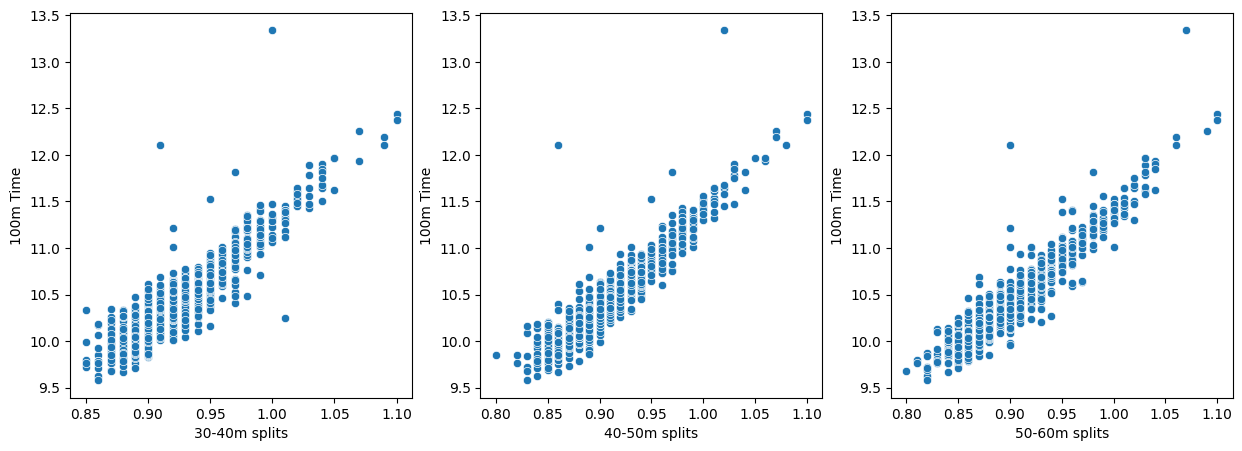

In [103]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

sns.scatterplot(x=fly_frame['fly_40'],y=fly_frame['100 m'], ax=ax1)
ax1.set(xlabel="30-40m splits",ylabel="100m Time")

sns.scatterplot(x=fly_frame['fly_50'],y=fly_frame['100 m'],ax=ax2)
ax2.set(xlabel="40-50m splits",ylabel="100m Time")

sns.scatterplot(x=fly_frame['fly_60'],y=fly_frame['100 m'], ax=ax3)
ax3.set(xlabel="50-60m splits",ylabel="100m Time")

plt.show()

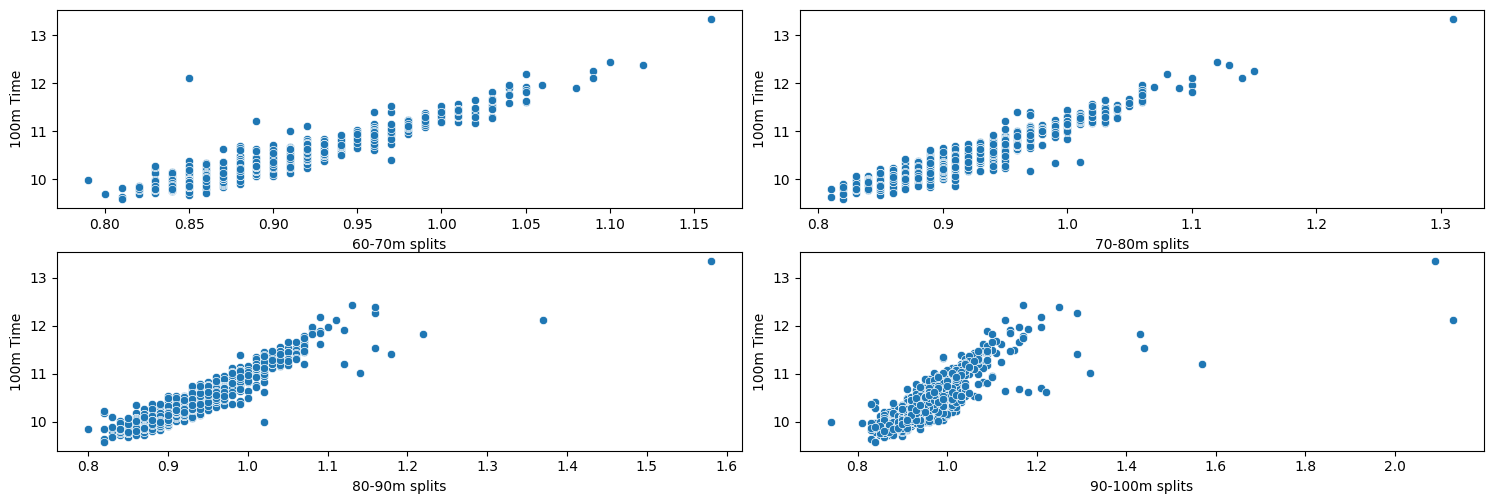

In [104]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15, 5))
f.tight_layout()
sns.scatterplot(x=fly_frame['fly_70'],y=fly_frame['100 m'], ax=ax1)
ax1.set(xlabel="60-70m splits",ylabel="100m Time")

sns.scatterplot(x=fly_frame['fly_80'],y=fly_frame['100 m'],ax=ax2)
ax2.set(xlabel="70-80m splits",ylabel="100m Time")

sns.scatterplot(x=fly_frame['fly_90'],y=fly_frame['100 m'], ax=ax3)
ax3.set(xlabel="80-90m splits",ylabel="100m Time")

sns.scatterplot(x=fly_frame['fly_100'],y=fly_frame['100 m'], ax=ax4)
ax4.set(xlabel="90-100m splits",ylabel="100m Time")



plt.show()

## 100m times as a function of velocities

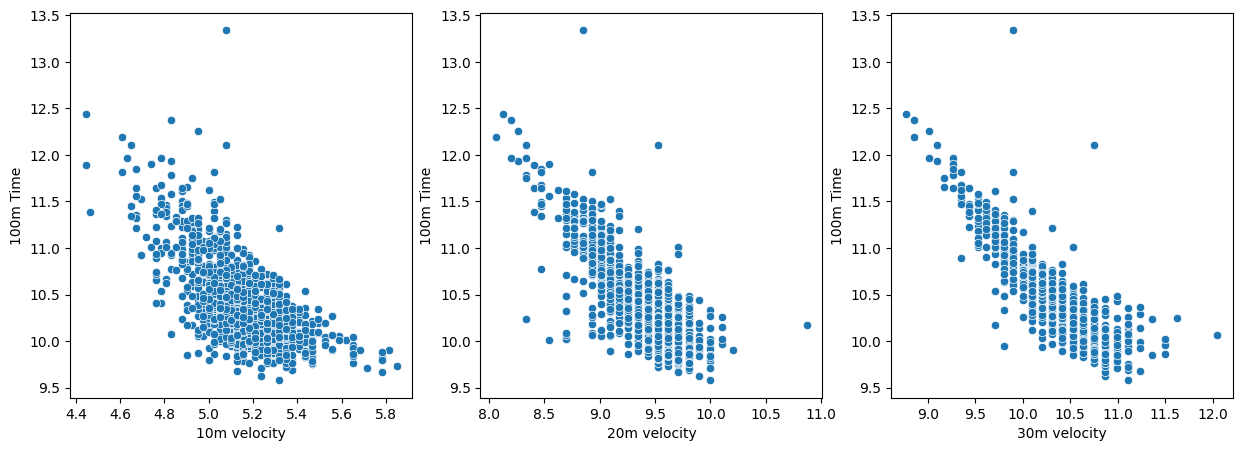

In [105]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

sns.scatterplot(x=fly_frame['10m_velocity'],y=fly_frame['100 m'], ax=ax1)
ax1.set(xlabel="10m velocity",ylabel="100m Time")

sns.scatterplot(x=fly_frame['20m_velocity'],y=fly_frame['100 m'], ax=ax2)
ax2.set(xlabel="20m velocity",ylabel="100m Time")

sns.scatterplot(x=fly_frame['30m_velocity'],y=fly_frame['100 m'], ax=ax3)
ax3.set(xlabel="30m velocity",ylabel="100m Time")

plt.show()

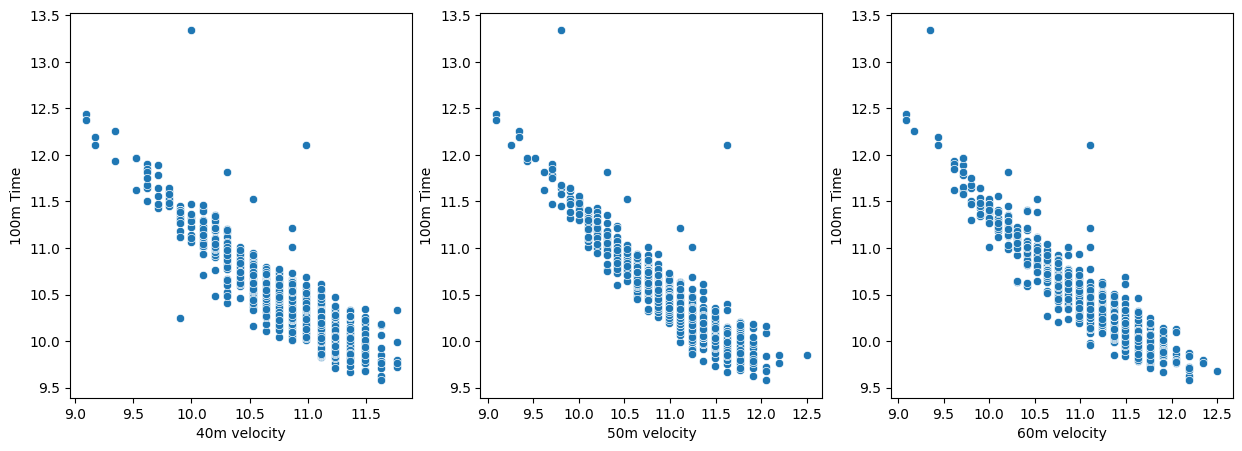

In [106]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

sns.scatterplot(x=fly_frame['40m_velocity'],y=fly_frame['100 m'], ax=ax1)
ax1.set(xlabel="40m velocity",ylabel="100m Time")

sns.scatterplot(x=fly_frame['50m_velocity'],y=fly_frame['100 m'], ax=ax2)
ax2.set(xlabel="50m velocity",ylabel="100m Time")

sns.scatterplot(x=fly_frame['60m_velocity'],y=fly_frame['100 m'], ax=ax3)
ax3.set(xlabel="60m velocity",ylabel="100m Time")

plt.show()

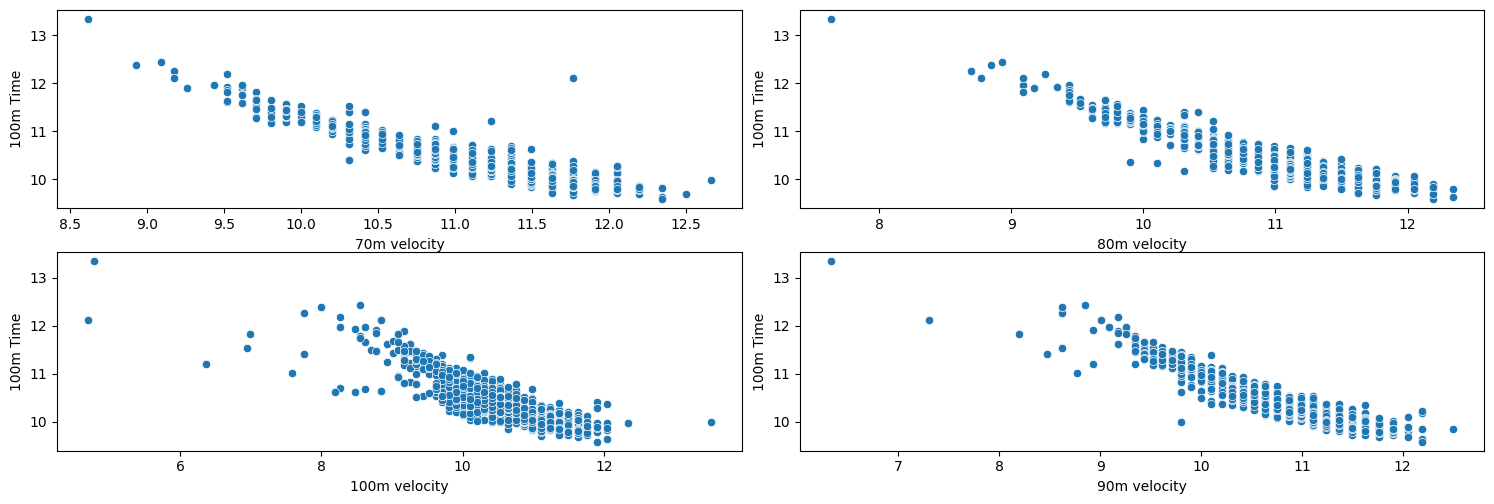

In [107]:
f, ((ax1, ax2),(ax4, ax3)) = plt.subplots(2,2,figsize=(15, 5))
f.tight_layout()

sns.scatterplot(x=fly_frame['70m_velocity'],y=fly_frame['100 m'], ax=ax1)
ax1.set(xlabel="70m velocity",ylabel="100m Time")

sns.scatterplot(x=fly_frame['80m_velocity'],y=fly_frame['100 m'], ax=ax2)
ax2.set(xlabel="80m velocity",ylabel="100m Time")

sns.scatterplot(x=fly_frame['90m_velocity'],y=fly_frame['100 m'], ax=ax3)
ax3.set(xlabel="90m velocity",ylabel="100m Time")

sns.scatterplot(x=fly_frame['100m_velocity'],y=fly_frame['100 m'], ax=ax4)
ax4.set(xlabel="100m velocity",ylabel="100m Time")
plt.show()

In [108]:
%pip install statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [109]:
import statsmodels.formula.api as smf
warnings.simplefilter(action='ignore', category=FutureWarning)

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("fly_20")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("fly_30")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("fly_40")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("fly_50")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("fly_60")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("fly_70")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("fly_80")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("fly_90")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [110]:
warnings.simplefilter(action='ignore', category=FutureWarning)

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("10m_velocity")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("20m_velocity")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("30m_velocity")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("40m_velocity")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("50m_velocity")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("60m_velocity")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("70m_velocity")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))

flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("80m_velocity")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))
flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("90m_velocity")', data=fly_frame).fit()
print(round(flyframe_relsplit.pvalues[1],3))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [111]:
flyframe_relsplit = smf.ols(formula='Q("100 m") ~ Q("fly_60")', data=fly_frame).fit()
flyframe_relsplit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Q("100 m")   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                 1.156e+04
Date:                Sun, 07 Sep 2025   Prob (F-statistic):               0.00
Time:                        16:15:40   Log-Likelihood:                 824.24
No. Observations:                1446   AIC:                            -1644.
Df Residuals:                    1444   BIC:                            -1634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.7998      0.080     22.456      0.000       1.643       1.957
Q("fly_60")     9.5613      0.089    107.515      0.000       9.387       9.736
==============================================================================
Omnibus:                      928.168   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36506.213
Skew:                           2.406   Prob(JB):                         0.00
Kurtosis:                      27.140   Cond. No.                         44.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [150]:
%pip install scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [153]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
clf = LinearRegression()

test_train_df = fly_frame
test_train_df.dropna(subset=['fly_50','100 m'],inplace=True)
X = pd.DataFrame(test_train_df['fly_50']) # Feature
y = pd.DataFrame(test_train_df['100 m']) # Target variable

# Train, add random_state=42 to the train_test_split call if we want it to choose the same sample each time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_train)
clf.score(X_test,y_test)

/var/folders/w_/x1l28kg103j3s4tk96h_n8840000gn/T/ipykernel_69522/3726987302.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_train_df.dropna(subset=['fly_50','100 m'],inplace=True)


0.9083717301173494

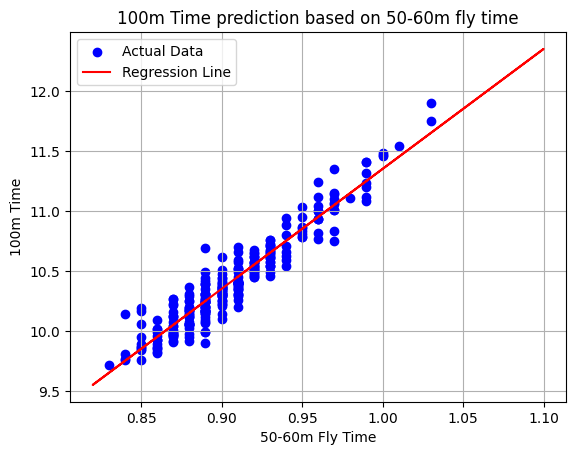

In [154]:
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.plot(X_train, y_pred, color='red', label='Regression Line')
plt.xlabel('50-60m Fly Time')
plt.ylabel('100m Time')
plt.title('100m Time prediction based on 40-50m fly time')
plt.legend()
plt.grid(True)
plt.show()